In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [2]:
data = pd.read_csv('DB_TIME_HISTORY.csv')

,INST_NAME,SNAP_ID,SNAP_PERIOD,SNAP_DATE,DB_TIME,DB_NAME,CREATED
0,ACTDB11,43571.0,2019-01-01-0000~0030,20190101.0,19.55,ACTDB1,20190611 16:39:01
1,ACTDB12,43571.0,2019-01-01-0000~0030,20190101.0,6.40,ACTDB1,20190611 16:39:01
2,ACTDB13,43571.0,2019-01-01-0000~0030,20190101.0,3.30,ACTDB1,20190611 16:39:01
3,CRMCENDB1,43613.0,2019-01-01-0000~0030,20190101.0,3.59,CRMCENDB,20190611 16:39:01
4,CRMCENDB2,43613.0,2019-01-01-0000~0030,20190101.0,1.80,CRMCENDB,20190611 16:39:01


In [4]:
data0 = data.groupby('INST_NAME').get_group('ACTDB11')
data0.head()

,INST_NAME,SNAP_ID,SNAP_PERIOD,SNAP_DATE,DB_TIME,DB_NAME,CREATED
0,ACTDB11,43571.0,2019-01-01-0000~0030,20190101.0,19.55,ACTDB1,20190611 16:39:01
17,ACTDB11,43572.0,2019-01-01-0030~0100,20190101.0,36.33,ACTDB1,20190611 16:39:01
34,ACTDB11,43573.0,2019-01-01-0100~0130,20190101.0,28.35,ACTDB1,20190611 16:39:01
51,ACTDB11,43574.0,2019-01-01-0130~0200,20190101.0,31.55,ACTDB1,20190611 16:39:01
68,ACTDB11,43575.0,2019-01-01-0200~0230,20190101.0,33.29,ACTDB1,20190611 16:39:01


In [6]:
time = data0['SNAP_PERIOD']
time = [i[:15] for i in time] #取左段时间（0000表示0点，如果取右段时间就到下一天了）
time = pd.to_datetime(time,format = '%Y-%m-%d-%H%M')
time = list(time)

In [7]:
#时间取整
for i in range(len(time)):
    if time[i].minute>0 and time[i].minute<30:
        time[i] = time[i] - datetime.timedelta(minutes=time[i].minute) #向下
        if time[i] == time[i-1]:
            time[i] = time[i] + datetime.timedelta(minutes=30) #向上
    elif time[i].minute>30:
        time[i] = time[i] - datetime.timedelta(minutes=(time[i].minute-30))
        if time[i] == time[i-1]:
            time[i] = time[i] + datetime.timedelta(minutes=30)

In [86]:
#找到缺失值
time_new = pd.date_range(min(time),max(time),freq='1800s')
datanew = pd.DataFrame(index=time_new,columns=['DB_TIME'])
datanew.loc[time,'DB_TIME']=list(data0['DB_TIME'])

In [9]:
datanew.loc[datanew['DB_TIME']<0] #负值

,DB_TIME
2019-02-14 21:00:00,-117053
2020-08-22 12:00:00,-15768.7


In [10]:
datanew.loc[datanew['DB_TIME']<0,'DB_TIME']=np.nan #把负值当成缺失值

In [11]:
datanew[datanew['DB_TIME'].isnull()] #缺失值

,DB_TIME
2019-02-14 21:00:00,NaN
2020-06-13 23:30:00,NaN
2020-06-14 00:00:00,NaN
2020-06-14 00:30:00,NaN
2020-06-14 01:00:00,NaN
2020-06-14 01:30:00,NaN
2020-06-14 02:30:00,NaN
2020-08-03 23:00:00,NaN
2020-08-03 23:30:00,NaN
2020-08-04 00:00:00,NaN


In [15]:
x = datanew['DB_TIME']

In [16]:
np.where(x.isnull())

(array([ 2154, 25439, 25440, 25441, 25442, 25443, 25445, 27886, 27887,
        27888, 27889, 27890, 27891, 27892, 27893, 27894, 27895, 27896,
        27897, 27898, 28775, 28776], dtype=int64),)

In [72]:
w = 6
xpre = []   #拟合预测值序列
upr = []    #上限序列
x_h = list(x[:96])   #前两个周期的数据
for h in range(96,4800):
    model_h = ExponentialSmoothing(x_h, trend='add', seasonal='add', seasonal_periods=48).fit()
    xpre_h = model_h.predict()[0]    #基线取值baseline(h)，下一时刻的预测值
    xpre.append(xpre_h)
    upr_h = xpre_h + w * model_h.resid.std()   #时刻h的上界
    upr.append(upr_h)   #所有上界
    
    if np.isnan(x[h]):   #时刻h+1的空值处理与离群值修正
        xnew_h = xpre_h    
    else :
        xnew_h = min(upr_h,x[h])
    
    x_h = x_h + [xnew_h] #时刻h使用的训练数据
upr_new = [max(upr[i-1],upr[i],upr[i+1]) for i in range(1,len(upr)-1)]

C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodel

C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodel

C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodel

C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodel

C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodel

C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodel

C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodel

C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodel

C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodel

C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodel

C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodel

C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodel

C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodel

C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodel

C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodel

C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodel

C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodel

C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodel

C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodel

C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodel

C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodel

C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodel

C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodel

C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodel

C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodel

C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodel

C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodel

C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodel

C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodel

C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodel

C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodel

C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodel

C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodel

C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodel

C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodel

C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodel

C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodel

C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodel

C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodel

C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodel

C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodel

C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodel

C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodel

C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodel

C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodel

C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodel

C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodel

C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodel

C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodel

C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodel

C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodel

C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodel

C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodel

C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodel

C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodel

C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodel

C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodel

C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodel

C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodel

C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodel

C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodel

C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodel

C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodel

C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodel

C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodel

C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodel

C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodel

C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodel

C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodel

C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodel

C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodel

C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodel

C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodel

C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodel

C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodel

C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodel

C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodel

C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodel

C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodel

C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodel

C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodel

C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodel

C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodel

C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodel

C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodel

C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodel

C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodel

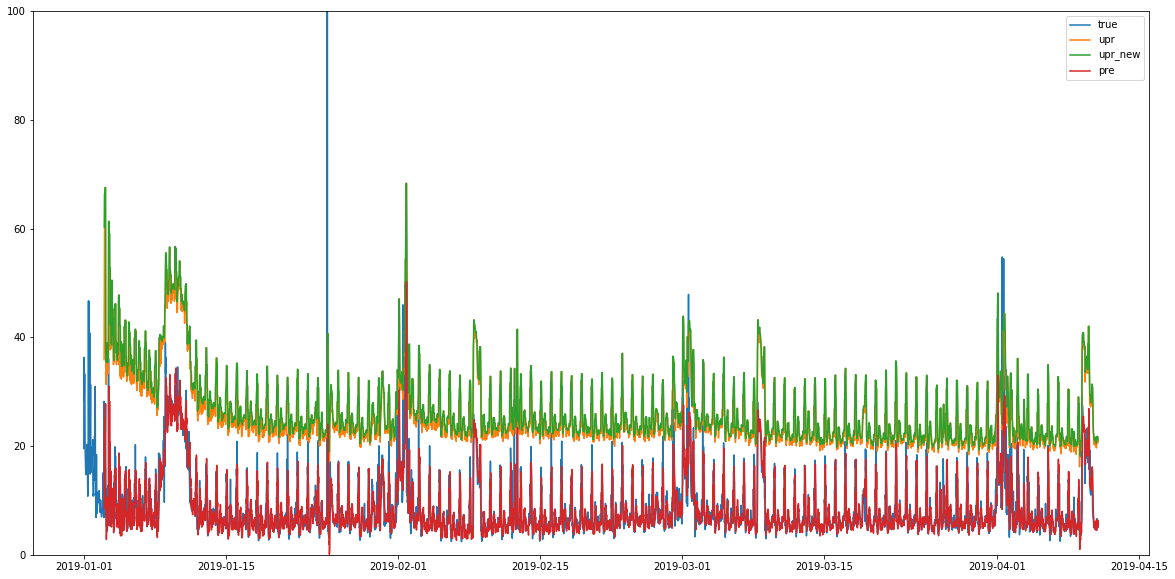

In [75]:
plt.figure(figsize=(20,10))
plt.plot(datanew.index[:4800],x[:4800],label = 'true')
plt.plot(datanew.index[96:4800],upr,label = 'upr')
plt.plot(datanew.index[97:4799],upr_new,label = 'upr_new')
plt.plot(datanew.index[97:4801],xpre,label = 'pre')
plt.legend()
plt.ylim(0,100)
plt.show()